In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [91]:
# read excel file
df = pd.read_excel('Churn Dataset.xlsx')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


In [92]:
# dataset info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Data Cleaning & Conversion

In [93]:
# checking null values

df.isnull().sum().sum()

0

In [94]:
# drop unnecessary column

df = df.drop('customerID', axis=1)

In [95]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Double check for any NaNs after conversion
df.dropna(inplace=True)

## Data visualization

In [53]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [54]:
# customer retained and left 

retained_customer = df[df.Churn == 'No'].shape[0]
churned_customer = df[df.Churn == 'Yes'].shape[0]
total = retained_customer + churned_customer

print('customers that stayed:', int(retained_customer / total * 100),'%')
print('customers that left:', int(churned_customer / total * 100),'%')

customers that stayed: 73 %
customers that left: 26 %


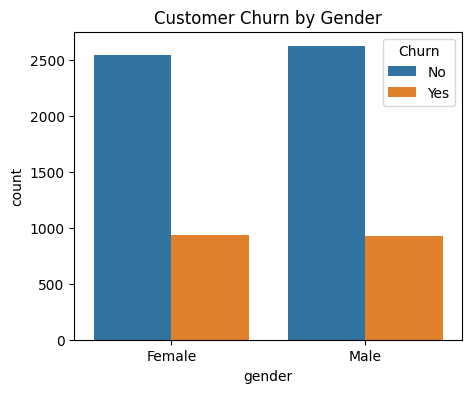

In [55]:
# plot churn

plt.figure(figsize=(5,4))
sns.countplot(x='gender', hue='Churn', data=df)
plt.title('Customer Churn by Gender')
plt.show()

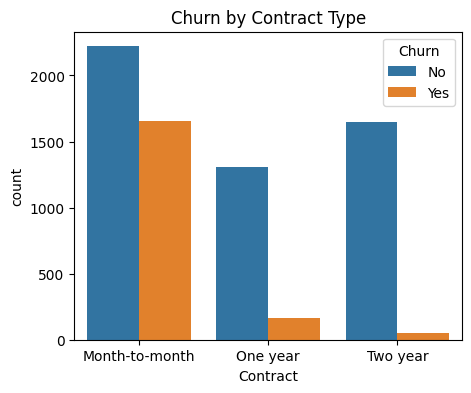

In [56]:
plt.figure(figsize=(5,4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.show()

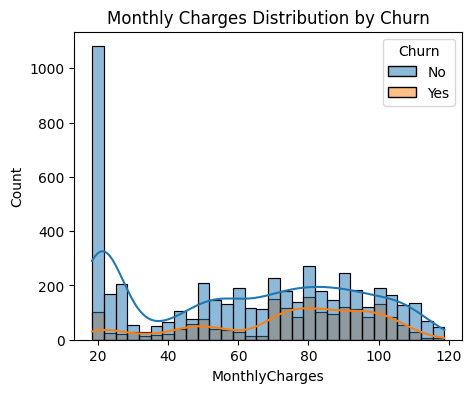

In [57]:
plt.figure(figsize=(5,4))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True, bins=30)
plt.title('Monthly Charges Distribution by Churn')
plt.show()

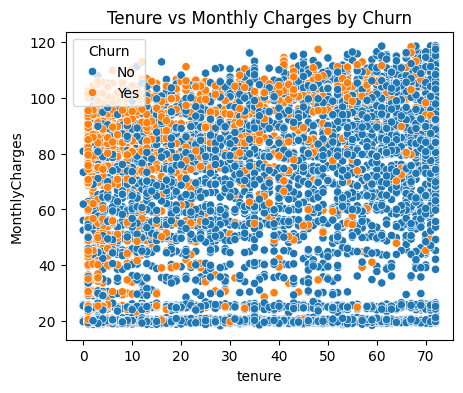

In [58]:
plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn')
plt.title('Tenure vs Monthly Charges by Churn')
plt.show()

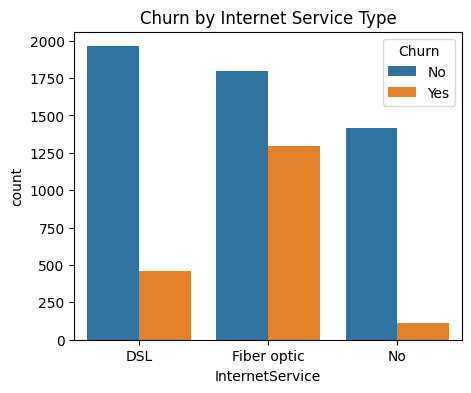

In [59]:
plt.figure(figsize=(5,4))
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title('Churn by Internet Service Type')
plt.show()

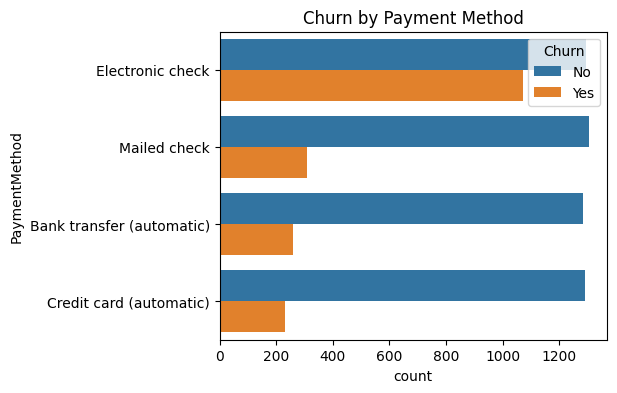

In [60]:
plt.figure(figsize=(5,4))
sns.countplot(y='PaymentMethod', hue='Churn', data=df)
plt.title('Churn by Payment Method')
plt.show()

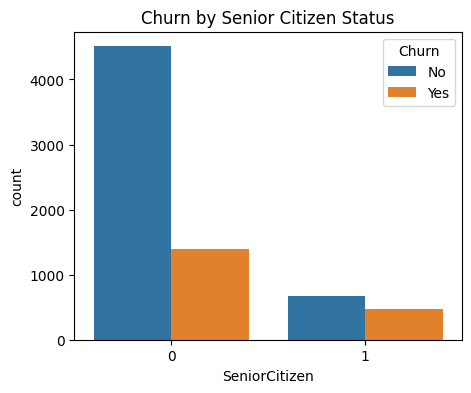

In [61]:
plt.figure(figsize=(5,4))
sns.countplot(x='SeniorCitizen', hue='Churn', data=df)
plt.title('Churn by Senior Citizen Status')
plt.show()

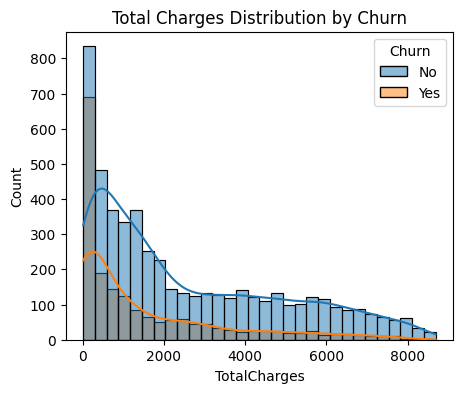

In [62]:
plt.figure(figsize=(5,4))
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
sns.histplot(data=df, x='TotalCharges', hue='Churn', bins=30, kde=True)
plt.title('Total Charges Distribution by Churn')
plt.show()

## Encode Categorical Features

In [96]:
# features 
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'gender']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

# Encode remaining features
cat_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

## Feature Scaling

In [97]:
scaler = StandardScaler()

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'numAdminTickets', 'numTechTickets']
df[num_cols] = scaler.fit_transform(df[num_cols])

## Modeling and Training Models

In [98]:
x = df.drop('Churn', axis=1)
y = df['Churn']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [99]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True),
    "Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    acc = accuracy_score(ytest, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

Logistic Regression Accuracy: 0.8515
Decision Tree Accuracy: 0.7967
Random Forest Accuracy: 0.8500
SVM Accuracy: 0.8479
Gradient Boosting Accuracy: 0.8529


In [105]:
best_model = models['Gradient Boosting']
y_pred = best_model.predict(xtest)

print("\nConfusion Matrix:\n", confusion_matrix(ytest, y_pred))
print("\nClassification Report:\n", classification_report(ytest, y_pred))


Confusion Matrix:
 [[941  92]
 [115 259]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1033
           1       0.74      0.69      0.71       374

    accuracy                           0.85      1407
   macro avg       0.81      0.80      0.81      1407
weighted avg       0.85      0.85      0.85      1407



## Feature Importances

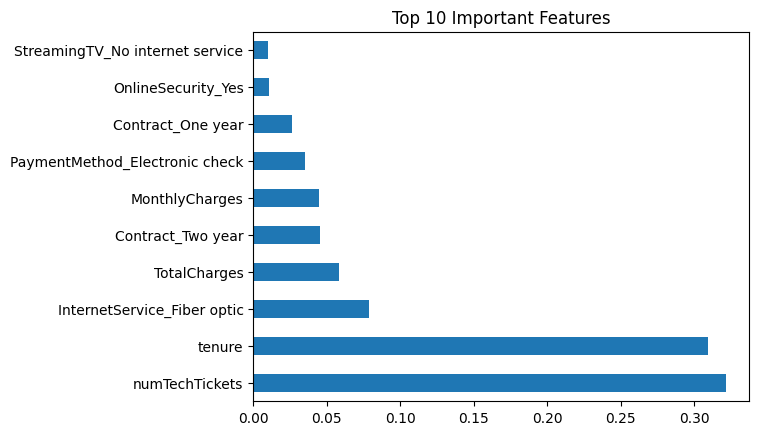

In [106]:
importances = pd.Series(best_model.feature_importances_, index=x.columns)
importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()

In [107]:
cv_scores = cross_val_score(best_model, x, y, cv=5)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Average CV Accuracy:", np.mean(cv_scores))

Cross-Validation Accuracy Scores: [0.86069652 0.86069652 0.84423898 0.86699858 0.86201991]
Average CV Accuracy: 0.8589301005640362
